# Agent

에이전트(Agents)는 언어 모델과 도구를 결합하여 작업에 대해 추론하고, 사용할 도구를 결정하며, 솔루션을 향해 반복적으로 작업할 수 있는 시스템을 만듭니다. `create_agent`는 프로덕션에 바로 사용 가능한 에이전트 구현을 제공합니다. LLM 에이전트는 목표를 달성하기 위해 도구를 반복적으로 실행합니다.

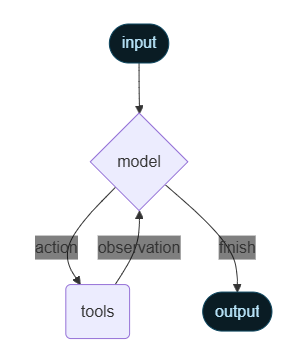

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

### LLM 연결

In [12]:
from langchain.chat_models import init_chat_model

# model = init_chat_model("gpt-5-nano", model_provider="openai")
model = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

### ReAct Agent 생성

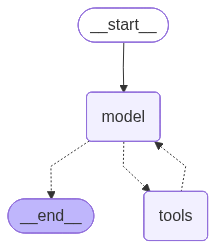

In [13]:
from langchain.agents import create_agent
from langchain.tools import tool

@tool
def search_database(query: str, limit: int = 10) -> str:
    """쿼리와 일치하는 레코드를 고객 데이터베이스에서 검색합니다.
    Args:
        query: 검색할 검색어
        limit: 반환할 최대 결과 수
    """
    return f"'{query}'에 대해 {limit}개의 결과를 찾았습니다"

@tool
def search_db(query: str) -> str:
    """정보를 검색하는 함수"""
    return f"검색 결과: {query}"


@tool
def get_weather(location: str) -> str:
    """특정 지역의 날씨 정보를 가져오는 함수"""
    return f"{location}의 날씨: 맑음, 72°F"


tools = [search_database, search_db, get_weather]

agent = create_agent(
    model,
    tools=tools
)
agent

## 동적 모델(Dynamic model)

동적 모델은 현재 **상태(state)** 와 **컨텍스트(context)** 를 기반으로 **런타임** 에 선택됩니다. 이를 통해 정교한 라우팅 로직과 비용 최적화가 가능합니다. 동적 모델을 사용하려면 `@wrap_model_call` 데코레이터를 사용하여 요청의 모델을 수정하는 미들웨어를 생성합니다.

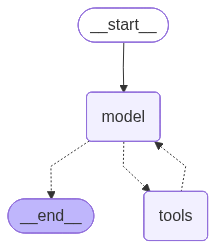

In [14]:
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

from langchain.agents import create_agent
from langchain.agents.middleware import wrap_model_call, ModelRequest, ModelResponse

# basic_model = ChatOpenAI(model="gpt-5-nano")
# advanced_model = ChatOpenAI(model="gpt-5-mini")

basic_model = ChatGoogleGenerativeAI(model="gemini-2.5-flash-light")
advanced_model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

@wrap_model_call
def dynamic_model_selection(request: ModelRequest, handler) -> ModelResponse:
    """대화의 복잡도에 따라 사용할 모델을 동적으로 선택"""

    # 현재 대화에서 주고받은 메시지 개수를 계산
    message_count = len(request.state["messages"])

    # 메시지가 10개를 초과하면 복잡한 대화로 간주 → 고급 모델 사용
    if message_count > 10:
        # 긴 대화일 경우 고급(Advanced) 모델 사용
        model = advanced_model
    else:
        # 짧은 대화일 경우 기본(Basic) 모델 사용
        model = basic_model

    # 선택된 모델을 request에 설정
    request.model = model

    # handler를 호출하여 요청 처리 계속 진행
    return handler(request)

agent = create_agent(
    model=basic_model,  # Default model
    tools=tools,
    middleware=[dynamic_model_selection]
)
agent

## 도구 오류 처리 (Tool error handling)

도구 실행 중 발생하는 오류를 커스터마이징하려면, @wrap_tool_call 데코레이터를 사용하여 미들웨어(middleware) 를 생성하면 됩니다.

In [15]:
from langchain.agents import create_agent
from langchain.agents.middleware import wrap_tool_call
from langchain_core.messages import ToolMessage


@wrap_tool_call
def handle_tool_errors(request, handler):
    """도구 실행 중 발생하는 오류를 사용자 정의 메시지로 처리"""

    try:
        # 정상적으로 도구 요청을 처리
        return handler(request)

    except Exception as e:
        # 오류 발생 시 모델에게 사용자 친화적인 에러 메시지를 반환
        return ToolMessage(
            content=f"도구 오류: 입력값을 확인하고 다시 시도해주세요. (오류 내용: {str(e)})",
            tool_call_id=request.tool_call["id"]
        )

agent = create_agent(
    model=model,
    tools=[search_db, get_weather],
    middleware=[handle_tool_errors]
)

## 시스템 프롬프트 (System prompt)

에이전트가 작업을 수행하는 방식을 제어하려면 시스템 프롬프트(System prompt) 를 제공할 수 있습니다.  
이때, system_prompt 매개변수는 문자열(String) 형태로 지정할 수 있습니다.

In [16]:
agent = create_agent(
    model=model,
    tools=tools,
    system_prompt="당신은 도움이 되는 어시스턴트입니다. 간결하고 정확하게 답변하세요."
)

## 동적 시스템 프롬프트 (Dynamic system prompt)

실행 시점의 컨텍스트(runtime context) 나 에이전트 상태(agent state) 에 따라 시스템 프롬프트를 동적으로 변경해야 하는 고급 사용 사례에서는 미들웨어(middleware) 를 사용할 수 있습니다.  
@dynamic_prompt 데코레이터를 사용하면, 모델 요청(model request) 에 따라 시스템 프롬프트를 동적으로 생성하는 미들웨어를 만들 수 있습니다.

In [20]:
from typing import TypedDict

from langchain.agents import create_agent
from langchain.agents.middleware import dynamic_prompt, ModelRequest

class Context(TypedDict):
    user_role: str

@dynamic_prompt
def user_role_prompt(request: ModelRequest) -> str:
    """사용자 역할(user role)에 따라 시스템 프롬프트를 생성"""

    # 실행 컨텍스트(runtime context)에서 사용자 역할 정보를 가져옴
    # 기본값은 "user"
    user_role = request.runtime.context.get("user_role", "user")

    # 기본 프롬프트 정의
    base_prompt = "당신은 도움이 되는 어시스턴트입니다."

    # 사용자 역할에 따라 프롬프트를 다르게 설정
    if user_role == "expert":
        # 전문가(expert)인 경우: 기술적으로 자세한 답변을 제공
        return f"{base_prompt} 기술적으로 자세하고 전문적인 답변을 제공하세요."
    elif user_role == "beginner":
        # 초보자(beginner)인 경우: 쉬운 설명과 비전문 용어 사용
        return f"{base_prompt} 개념을 쉽게 설명하고 전문 용어 사용을 피하세요."

    return base_prompt

agent = create_agent(
    model=model,
    tools=tools,
    middleware=[user_role_prompt],
    context_schema=Context
)

# 실행 컨텍스트(context)에 따라 시스템 프롬프트가 동적으로 설정됨
result = agent.invoke(
    {
        "messages": [
            {"role": "user", "content": "기계 학습(machine learning)을 한 문장으로 설명해줘."}
        ]
    },
    context={"user_role": "expert"}  # 사용자 역할을 '전문가'로 지정
)

result['messages'][-1].pretty_print()

================================== Ai Message ==================================

[{'type': 'text', 'text': '기계 학습은 시스템이 명시적으로 프로그래밍되지 않고도 데이터로부터 학습하여 성능을 점진적으로 향상시키는 인공지능의 한 분야입니다.', 'extras': {'signature': 'CtYBAdHtim+CUvSMEHEk/WYFYRkkXy1aFRdCtGv44EJR63F/xBDsPjSGfV9zKeqtkN3ytKgP2tLn6inyBzfM/doFeka4iczgnIsf7zQ4xA/s8s7XMiQLuq4uwGqizTgvuv7cQY16LfpZW4YL7mMOhx8IXHNsrMy5SifEHqyUPyAx0nhRVh7r6mimFZn5inHWX9nX1YuyZwx2OIZM+q8j7aGrukGdfBMOqI7h5lVd3+NU3w9cWRbx3fBzKHKxaX1KBADr0ta6XIBEZZO4QDpBPpM7f3TmIdAJmQ=='}}]


## 호출 (Invocation)

에이전트는 State(상태) 에 대한 업데이트를 전달하여 호출할 수 있습니다.  
모든 에이전트는 상태 안에 메시지들의 시퀀스(sequence of messages) 를 포함하고 있으며, 에이전트를 호출하려면 새로운 메시지를 전달하면 됩니다.

In [22]:
agent = create_agent(
    model=model,
    tools=tools
)

result = agent.invoke(
    {"messages": [{"role": "user", "content": "LangChain 이란 무엇인지 한 문장으로 설명해줘."}]}
)

result['messages'][-1].pretty_print()

================================== Ai Message ==================================

LangChain은 대규모 언어 모델 (LLM)을 사용하여 애플리케이션을 개발하는 데 도움이 되는 프레임워크입니다.


## 구조화된 출력 (Structured output)

특정 상황에서는 에이전트가 정해진 형식의 출력 결과를 반환하도록 하고 싶을 때가 있습니다.  
이때 LangChain은 response_format 매개변수를 통해 구조화된 출력을 생성하는 여러 가지 방법을 제공합니다.

In [23]:
from pydantic import BaseModel
from langchain.agents import create_agent
from langchain.agents.structured_output import ToolStrategy

class ContactInfo(BaseModel):
    name: str
    email: str
    phone: str

agent = create_agent(
    model=model,
    tools=tools,
    response_format=ToolStrategy(ContactInfo)
)

result = agent.invoke({
    "messages": [{"role": "user", "content": "다음에서 연락처 정보를 추출하세요: John Doe, john@example.com, (555) 123-4567"}]
})

result["structured_response"]

ContactInfo(name='John Doe', email='john@example.com', phone='(555) 123-4567')